# CAR Variance and Covariance Tests

In [2]:
import numpy as np
from math import exp, sqrt
import matplotlib.pyplot as plt
import os
#os.chdir("/Users/mlysy/Documents/proj/buqDE/probDE")
!python3 setup.py install
from BayesODE import var_car, cov_car

'python3' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
def rootgen(r0, n):
    roots = np.zeros(n)
    r = r0
    for k in range(n):
        roots[k] = -r
        r = exp(r0*(k+1))
    return roots

## Variance as a function of time

In [4]:
r0 = 1
n = 3
roots = rootgen(r0, n) #All roots need to be negative
tseq = np.linspace(0.001,0.5,100)
V = var_car(tseq, roots)

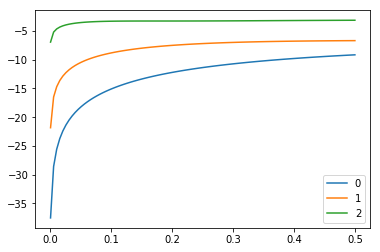

In [5]:
for k in range(len(roots)):
    plt.plot(tseq, np.log(V[:,k,k]), label=k)
plt.legend(loc='lower right')
plt.show()

## Correlation as a function of time

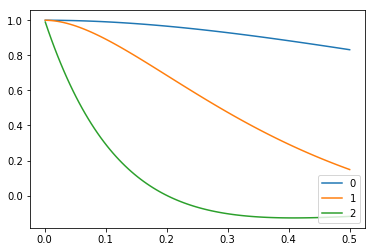

In [6]:
C = cov_car(tseq, roots, corr=True)
for k in range(len(roots)):
    plt.plot(tseq, C[:,k,k], label=k)
plt.legend(loc='lower right')
plt.show()

In [11]:
def getgamma(C):
    gamma = np.zeros(C.shape)
    for t in range(C.shape[0]):
        D = np.diag(np.diag(C[t]))
        print(D)
        D_half = np.linalg.cholesky(D)
        gamma[t] = np.linalg.multi_dot([np.linalg.pinv(D_half), C[t], D_half])
    return gamma

In [12]:
gamma = getgamma(C)

[[0.9999991  0.         0.        ]
 [0.         0.99998496 0.        ]
 [0.         0.         0.98960069]]
[[0.99996701 0.         0.        ]
 [0.         0.99946062 0.        ]
 [0.         0.         0.93846673]]
[[0.99988902 0.         0.        ]
 [0.         0.99821629 0.        ]
 [0.         0.         0.88941392]]
[[0.99976516 0.         0.        ]
 [0.         0.99628958 0.        ]
 [0.         0.         0.84236325]]
[[0.99959554 0.         0.        ]
 [0.         0.9937166  0.        ]
 [0.         0.         0.79723865]]
[[0.99938027 0.         0.        ]
 [0.         0.99053196 0.        ]
 [0.         0.         0.75396684]]
[[0.99911949 0.         0.        ]
 [0.         0.98676886 0.        ]
 [0.         0.         0.7124773 ]]
[[0.99881339 0.         0.        ]
 [0.         0.98245913 0.        ]
 [0.         0.         0.67270209]]
[[0.99846215 0.         0.        ]
 [0.         0.97763329 0.        ]
 [0.         0.         0.63457583]]
[[0.99806599 0.    

LinAlgError: Matrix is not positive definite

In [8]:
gamma = getgamma(C)
for k in range(len(roots)):
    plt.plot(tseq, np.log(gamma[:,k,k]), label=k)
plt.legend(loc='upper left')
plt.show()
#plt.plot(tseq,gamma)

LinAlgError: Matrix is not positive definite

In [ ]:
def decorrelation(roots, k, tol=1e-5):
    t = 0.1
    
    while True:
        cov = cov_car(np.array([t]), roots)
        gamma_k = getgamma(cov)[0][k,k]
        if abs(gamma_k-1/exp(1)) < tol:
            return t
        elif gamma_k>1/exp(1):
            t = t - t/100
        else:
            t = t + t/100

In [ ]:
decorrelation(roots, 2)

# Unit Test

In [ ]:
r0 = 1
roots = rootgen(r0, 3)

delta = -roots
D = np.diag(delta)
p = len(roots)
Q = np.zeros((p, p))

row = np.ones(p)
for i in range(p):
    Q[i] = row
    row = row*roots

Q_inv = np.linalg.pinv(Q)
Gamma = np.linalg.multi_dot([Q, D, Q_inv])

In [ ]:
from sympy import symbols, expand, Poly
s = symbols('s')
product = 1
for root in roots:
    product = product * (s - root)
coeffs = Poly(expand(product)).coeffs()
np.allclose(np.array(coeffs[:0:-1], dtype='float'),Gamma[-1])

In [ ]:
def V_euler_N1(Sigma, Delta_t):
    return Sigma*Delta_t

In [ ]:
def var_car_test(Q, D, Sigma, Delta_t):
    p = len(D)
    delta = np.diag(D)
    Q_inv = np.linalg.pinv(Q)
    Gamma = np.linalg.multi_dot([Q, D, Q_inv]) #Q*D*Q^-1
    Sigma_tilde = np.linalg.multi_dot([Q_inv, Sigma, Q_inv.T]) #Q^-1*Sigma*Q^-1'

    V_tilde = np.zeros((p,p))
    for i in range(p):
        for j in range(i, p):
            V_tilde[i,j] = Sigma_tilde[i,j] / (delta[i] + delta[j]) * (1- exp(- (delta[i] + delta[j]) * Delta_t)) #V_tilde
            V_tilde[j,i] = V_tilde[i,j]

    V = np.linalg.multi_dot([Q, V_tilde, Q.T]) #V_deltat
    return V

In [ ]:
Delta_T = 10**-np.linspace(5, 10, 10)
Q = np.ones((3,3))
D = np.diag([1,2,3])
Sigma = np.random.rand(3,3)
Sigma = Sigma.dot(Sigma.T)

compare = np.zeros(len(Delta_T))
for t in range(len(Delta_T)):
    euler = V_euler_N1(Sigma, Delta_T[t])
    true = var_car_test(Q, D, Sigma, Delta_T[t])
    compare[t] = np.max((abs(euler - true)/(abs(euler) + 0.1)))
    
plt.plot(np.log10(Delta_T), compare)

In [ ]:
def V_euler(B, N, Sigma, Gamma, delta_t):
    p = len(Gamma)
    X = np.zeros((N,p,B))
    Z = np.random.normal(0,1,(N,p,B))
    for n in range(N):
        deltaB_n = sqrt(delta_t)*Z[n]
        if n==0:
            X[n] = np.linalg.cholesky(Sigma).dot(deltaB_n)
        else:
            X[n] = X[n-1] + Gamma.dot(X[n-1])*delta_t + np.linalg.cholesky(Sigma).dot(deltaB_n)
    return np.cov(X[N-1])

In [ ]:
Q = np.ones((3,3))
Q_inv = np.linalg.pinv(Q)
D = np.diag([1,2,3])
Sigma = np.random.rand(3,3)
Sigma = Sigma.dot(Sigma.T)
Gamma = np.linalg.multi_dot([Q, D, Q_inv]) #Q*D*Q^-1

B = 10000
N = 10
T = 10**-np.linspace(5, 10, 10)

compare = np.zeros(len(T))
for t in range(len(T)):
    euler = V_euler(B, N, Sigma, Gamma, T[t]/N)
    true = var_car_test(Q, D, Sigma, T[t])
    compare[t] = np.max((abs(euler - true)/(abs(euler) + 0.1)))
    
plt.plot(np.log10(Delta_T), compare)